In [1]:
import json
import random
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_json("/Users/n.anokhin/Desktop/log/data.json", lines=True)
data["rnd"] = np.random.random(len(data))

data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments,rnd
0,next,2022-02-16 19:47:49.427,3255,2659,1.00,0.000919,41018.0,{'AA': 'C'},0.585019
1,next,2022-02-16 19:47:49.447,3255,41018,0.00,0.000801,28959.0,{'AA': 'C'},0.750944
2,next,2022-02-16 19:47:49.457,3255,28959,0.04,0.000496,41578.0,{'AA': 'C'},0.248728
3,next,2022-02-16 19:47:49.465,3255,41578,0.13,0.000561,213.0,{'AA': 'C'},0.649132
4,next,2022-02-16 19:47:49.473,3255,213,0.04,0.000476,10571.0,{'AA': 'C'},0.873405


## Compute track popularity

In [3]:
track_popularity = (
    data[data["rnd"] > 0.5]
    .groupby("track")["time"]
    .sum()
    .to_frame()
    .sort_values("time", ascending=False)
    .reset_index()
)

track_popularity.head()

,track,time
0,7925,4.00
1,443,4.00
2,162,4.00
3,2257,3.05
4,740,3.00


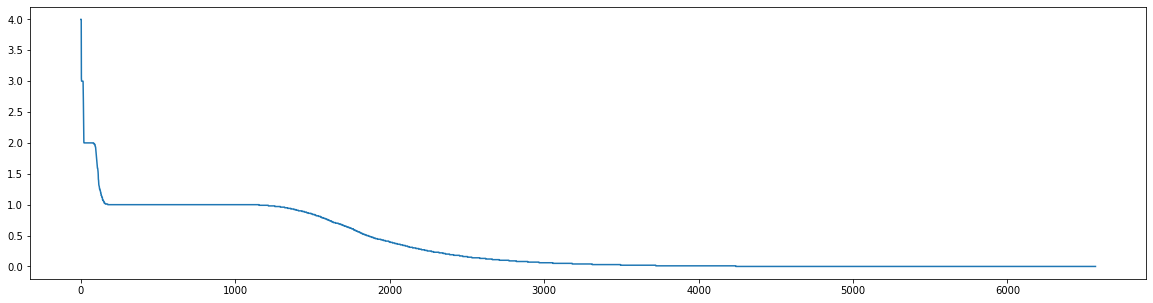

In [4]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(track_popularity.index.values, track_popularity["time"].values)

## Compute offline metrics

In [5]:
def precision_at(recommendations, track, k):
    return 1.0 / k * int(track in recommendations[:k])


    
def shuffled_precision_at(recommendations, track, k):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return precision_at(shuffled, track, k)


# TODO 1: Implement MRR metric here

In [6]:
tracks = track_popularity["track"].tolist()

t_p_10_udf = lambda track: precision_at(tracks, track, 10)
st_10_p_10_udf = lambda track: shuffled_precision_at(tracks[:10], track, 10)
st_100_p_10_udf = lambda track: shuffled_precision_at(tracks[:100], track, 10)
st_1000_p_10_udf = lambda track: shuffled_precision_at(tracks[:1000], track, 10)


metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

metrics["t_p_10_udf"] = metrics["track"].map(t_p_10_udf)
metrics["st_10_p_10_udf"] = metrics["track"].map(st_10_p_10_udf)
metrics["st_100_p_10_udf"] = metrics["track"].map(st_100_p_10_udf)
metrics["st_1000_p_10_udf"] = metrics["track"].map(st_1000_p_10_udf)

In [7]:
metrics[["t_p_10_udf", "st_10_p_10_udf", "st_100_p_10_udf", "st_1000_p_10_udf"]].describe()

,t_p_10_udf,st_10_p_10_udf,st_100_p_10_udf,st_1000_p_10_udf
count,1589.000000,1589.000000,1589.000000,1589.0
mean,0.000755,0.000755,0.000503,0.0
std,0.008660,0.008660,0.007080,0.0
min,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.0
75%,0.000000,0.000000,0.000000,0.0
max,0.100000,0.100000,0.100000,0.0


## Export data for prod

In [8]:
with open("/Users/n.anokhin/Desktop/top_tracks.json", "w") as top_tracks_file:
    json.dump(track_popularity["track"].tolist(), top_tracks_file)